# Table of contents
1. [Prototyped functions for PCA](#introduction)
2. [Testing for PCA](#paragraph1)
3. [Performance efficiency](#paragraph2)
    1. [Comparing standard PCA with implemented PCA](#subparagraph21)
    2. [Effect of number of partitions](#subparagraph22)

## Prototyped functions for PCA <a name="introduction"></a>
To utilize UDF architecture, we first perform PCA for each partition and perform incremental PCA on the reconstructed data to obtain the final PCA reduction.

In [189]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [190]:
import math
import time

import numpy as np
import scipy.sparse as sp
from scipy.linalg import norm, svd, qr
from scipy.stats import ortho_group
import matplotlib.pyplot as plt
from sklearn.decomposition import IncrementalPCA, PCA
from sklearn.preprocessing import StandardScaler

In [191]:
def diffsnorm(data, reconstruct):
    return norm(data-reconstruct)/norm(data+reconstruct)


In [192]:
def eig_error(eig_approx, eig):
    corr = np.linalg.norm(eig_approx-eig)
    corr = np.inner(eig_approx, eig)
    return corr


In [193]:
def subspace_error(U_approx, U):
    n_components = U.shape[1]
    A = U_approx.T.dot(U)
    B = U_approx.dot(U_approx.T)

    err = np.sqrt(n_components+np.trace(B.dot(B)) - 2 * np.trace(A.dot(A.T)))

    frob = np.linalg.norm(U-U_approx, ord='fro')

    return err/np.sqrt(n_components )


In [194]:
def modify_loading(loading, component):
    n_sample, n_component = loading.shape

    minimum = np.amin(loading, axis=0)
    maximum = np.amax(loading, axis=0)

    idx = []

    for i in range(n_sample):
        check = np.where((loading[i, :] == minimum) | (loading[i, :] == maximum), True, False)
        if True in check:
            idx.append(i)

    src_loading = loading[np.array(idx)]
    src_data = src_loading @ component

    return src_data


In [195]:
def process_partition(data, n_components, n_part):
    """
    Split data into four partitions and apply PCA on each partition
    """
    partition = []
    
    m = int(np.sqrt(n_part))
    n = int(np.sqrt(n_part))
    k = int(data.shape[0]/m)
    l = int(data.shape[1]/n)
        
    for i in range(m):
        for j in range(n):
            part = data[i*k:i*k+k, j*l:j*l+l, :, :]
            part_reshape = part.reshape((part.shape[0]*part.shape[1], part.shape[2]*part.shape[3]))
            U, S, V = svd(part_reshape, full_matrices=False)            
            partition.append((U[:, :n_components], S[:n_components], V[:n_components], part_reshape[0]))
    
    return partition


In [196]:
def merge(data, partition, n_components):
    """
    Merge PCA results from partitions
    """
    ipca = IncrementalPCA(n_components=n_components)
    
    for part in partition:
        reconstruct = modify_loading(part[0]*part[1], part[2])
        ipca.partial_fit(reconstruct)
    
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2] * data.shape[3]))
    data_transformed = ipca.fit_transform(data)
    reconstructed_data = ipca.inverse_transform(data_transformed)
    
    return data_transformed, reconstructed_data
        
        

In [197]:
def run_pca(data, n_components=100, noise_factor=None, n_part=4):
        
    sig_dim = int(math.sqrt(data.shape[0]))
    nav_dim = int(math.sqrt(data.shape[1]))
    
    assert (sig_dim ** 2) == data.shape[0]
    assert (nav_dim ** 2) == data.shape[1]
    
    new_data = data.copy()
    
    if noise_factor:
        noise = np.random.normal(0, 0.1, size=(new_data.shape[0], new_data.shape[1])) * noise_factor
        new_data += noise
    
    # reformat data into sig and nav dimension
    new_data = new_data.reshape((sig_dim, sig_dim, nav_dim, nav_dim))
    partition = process_partition(new_data, n_components, n_part)
    data_transformed, reconstructed_data = merge(new_data, partition, n_components)
       
    return data_transformed, reconstructed_data

In [198]:
from collections import Counter

def max_norm(reconstructed_data, benchmark_data):
    diff = np.abs(reconstructed_data - benchmark_data)
    max_idx = np.argmax(diff, axis=0).tolist()
    count = Counter(max_idx)
    
    return count.most_common(1)

In [199]:
def compare_benchmark(data, n_components=100, bool_time=False):
    """
    Compare PCA with standard PCA libraries for benchmarking purpose
    """
    start = time.time()
    
    data_transformed, reconstructed_data = run_pca(data, n_components)
    
    end = time.time()
    
    new_time = end - start

    norm_diff = diffsnorm(reconstructed_data, data)
    
    start = time.time()
    
    assert len(data.shape) == 2
    pca = PCA(n_components=n_components)
    pca.fit(data)
    
    transformed_data = pca.fit_transform(data)
    benchmark_reconstruct = pca.inverse_transform(transformed_data)
    
    end = time.time()
    
    orig_time = end - start

    benchmark_diff = diffsnorm(benchmark_reconstruct, data)
    
    transformed_diff = diffsnorm(np.abs(data_transformed), np.abs(transformed_data))
    
    if bool_time:
        print(f"For the implemented PCA, it took {new_time}s. For standard PCA, it took {orig_time}s")
        return norm_diff, benchmark_diff, transformed_diff, new_time, orig_time
    
    return norm_diff, benchmark_diff, transformed_diff

## Testing for PCA <a name="paragraph1"></a>
Various ways of testing the performance of implemented PCA algorithm

## data prep

In [200]:
component = ortho_group.rvs(dim=1024)[:100, :]

In [201]:
# standard data generated by 100 components
loading = np.random.rand(1024, 100)
data = loading @ component
np.random.shuffle(data.T)

In [202]:
# random noisy data
noise_data = np.random.rand(1024, 1024)

In [203]:
# A component contained within a single frame
last_component, new_component = component[99], component[:99]
loading = np.random.rand(1024, 99)
single_data = loading @ new_component

In [204]:
# Scale components differently to check if PCA catches them
def scale_data(data, order):
    
    scaler = np.logspace(order, 1, 1024).T
    scaler = scaler.reshape((-1, 1)).T
    np.random.shuffle(scaler.T)
    scaler = np.repeat(scaler, repeats=100, axis=0)
    
    new_component = np.multiply(scaler, component)

    loading = np.random.rand(1024, 100)

    scaled_data = loading @ new_component
    np.random.shuffle(scaled_data.T)
    
    return scaled_data

In [205]:
# Include frames that are pure random noise
def noise_frame(perc):
    new_data = np.random.rand(1024, 100) @ component
    perc_num = int(1024 * perc)
    new_data = new_data[:perc_num]
    random_data = np.random.rand(1024-perc_num, 1024)
    noise_frame_data = np.vstack((new_data, random_data))
    
    return noise_frame_data
    
    

## Data generated using 100 components vs Noisy data (w/ dimension 1024)

In [206]:
for n_component in range(10, 200, 10):
    U, S, V = svd(data, full_matrices=False)
    U, S, V = U[:, :n_component], S[:n_component], V[:n_component]
    reconstructed_data = ((data @ V.T) @ V)
    norm_diff = diffsnorm(reconstructed_data, data)
    print(f"norm difference wih {n_component} components using full batch data: {norm_diff}")

norm difference wih 10 components using full batch data: 0.2509883399894797
norm difference wih 20 components using full batch data: 0.22636982538305456
norm difference wih 30 components using full batch data: 0.20294092856832835
norm difference wih 40 components using full batch data: 0.18016637819490938
norm difference wih 50 components using full batch data: 0.1579409787345893
norm difference wih 60 components using full batch data: 0.13546056292505945
norm difference wih 70 components using full batch data: 0.11239842643378377
norm difference wih 80 components using full batch data: 0.08785260835782714
norm difference wih 90 components using full batch data: 0.059084700850574226
norm difference wih 100 components using full batch data: 5.491736303786883e-16
norm difference wih 110 components using full batch data: 5.370974818596922e-16
norm difference wih 120 components using full batch data: 5.381091379020052e-16
norm difference wih 130 components using full batch data: 5.39335785

In [207]:
for n_component in range(10, 200, 10):
    U, S, V = svd(noise_data, full_matrices=False)
    U, S, V = U[:, :n_component], S[:n_component], V[:n_component]
    reconstructed_data = (noise_data @ V.T) @ V
    norm_diff = diffsnorm(reconstructed_data, noise_data)
    print(f"norm difference wih {n_component} components using full batch data: {norm_diff}")

norm difference wih 10 components using full batch data: 0.2711192940325316
norm difference wih 20 components using full batch data: 0.2650468708168873
norm difference wih 30 components using full batch data: 0.2592442571816564
norm difference wih 40 components using full batch data: 0.2536239307296545
norm difference wih 50 components using full batch data: 0.2481639316386395
norm difference wih 60 components using full batch data: 0.2428697568973682
norm difference wih 70 components using full batch data: 0.23771619771508007
norm difference wih 80 components using full batch data: 0.23271105432869893
norm difference wih 90 components using full batch data: 0.2278231079939225
norm difference wih 100 components using full batch data: 0.22305638932907346
norm difference wih 110 components using full batch data: 0.21837596535981124
norm difference wih 120 components using full batch data: 0.21379865262603276
norm difference wih 130 components using full batch data: 0.20931553651380233
no

In [152]:
data_transformed, reconstructed_data = run_pca(data, n_components=100)
norm_diff = diffsnorm(reconstructed_data, data)
print(f"norm difference between original and reconstructed data: {norm_diff}")

norm difference between original and reconstructed data: 6.019234375436117e-16


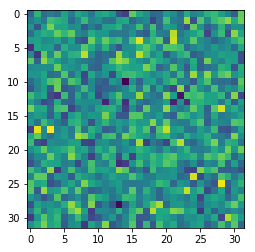

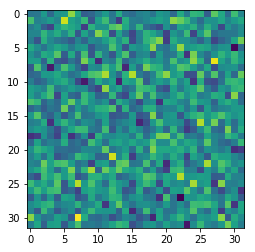

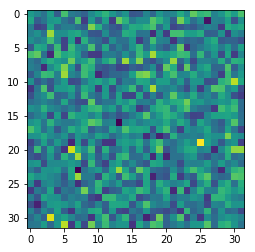

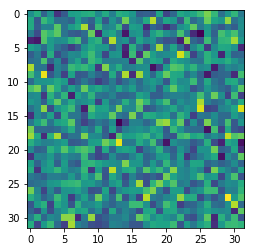

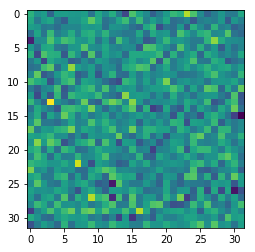

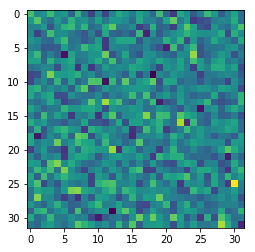

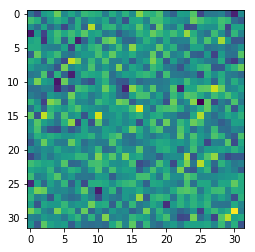

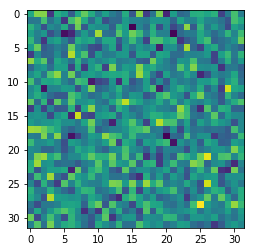

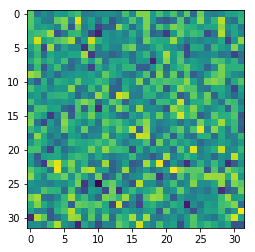

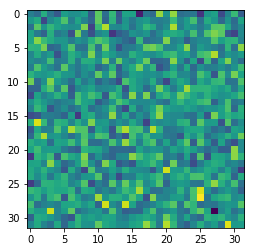

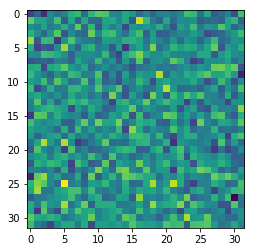

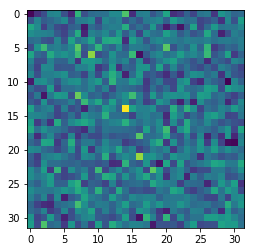

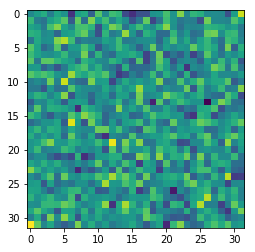

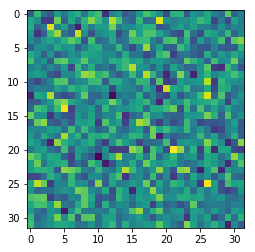

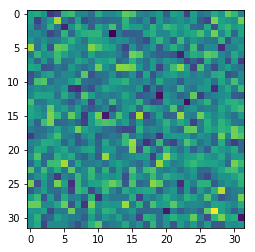

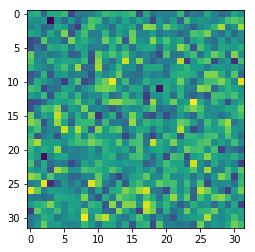

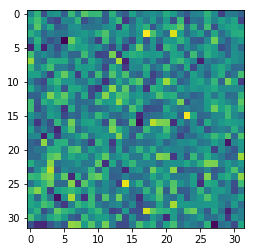

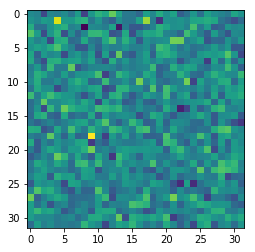

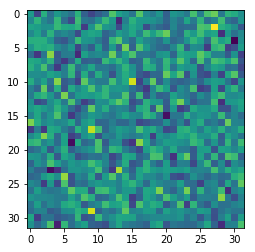

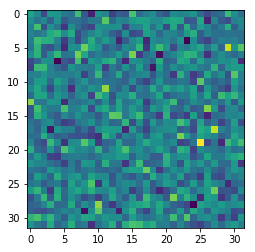

In [153]:
# visualize first 20 components
for i in range(20):
    components = data_transformed[:, i]
    vis = components.reshape((32, 32))

    f, axes = plt.subplots()
    axes.imshow(vis)

In [154]:
data_transformed, reconstructed_data = run_pca(data)
norm_diff = diffsnorm(reconstructed_data, data)
print(f"norm difference between original and reconstructed data: {norm_diff}")

norm difference between original and reconstructed data: 6.019234375436117e-16


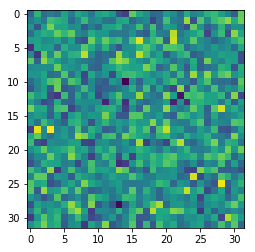

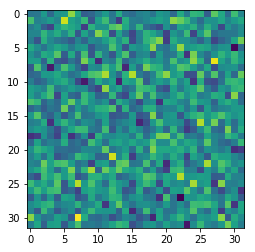

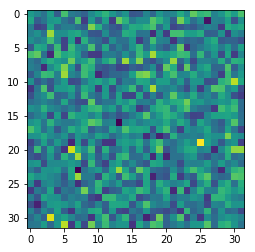

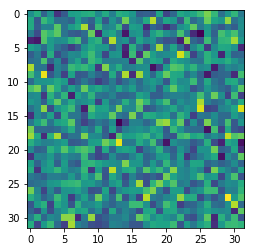

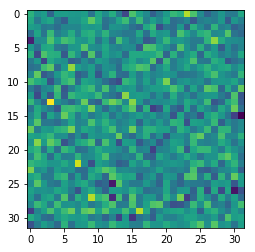

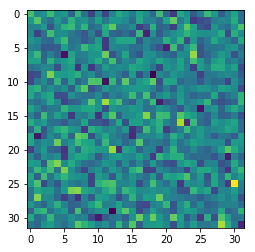

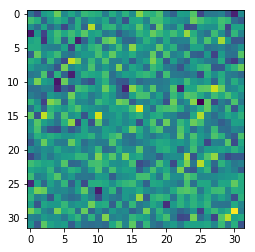

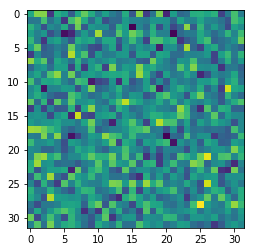

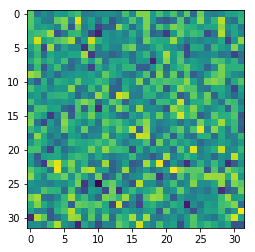

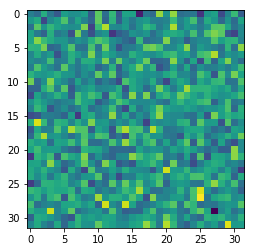

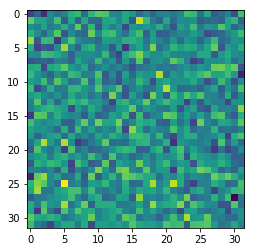

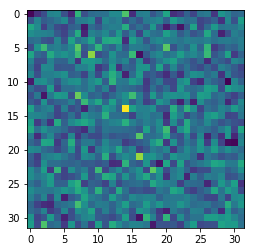

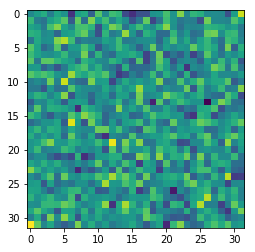

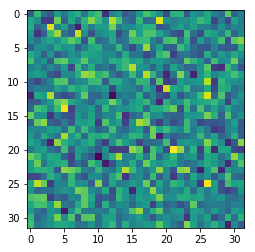

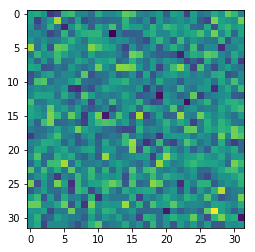

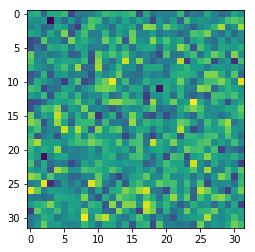

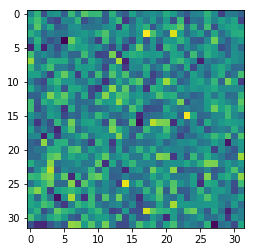

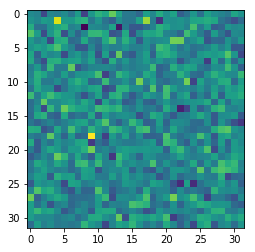

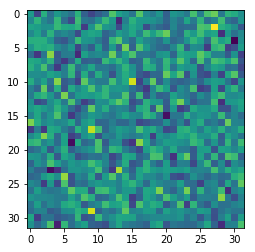

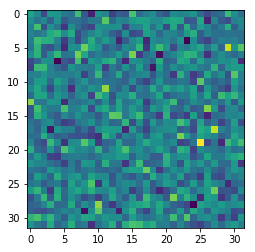

In [155]:
# visualize first 20 components
for i in range(20):
    components = data_transformed[:, i]
    vis = components.reshape((32, 32))

    f, axes = plt.subplots()
    axes.imshow(vis)


# A component contained only within a single frame

In [156]:
for factor in np.arange(0.05, 1, 0.2):
    new_single = single_data.copy()
    new_single[0, :] += last_component * factor
    print("99 components")
    data_transformed, reconstructed_data = run_pca(new_single, n_components=99)
    print("100 components")
    data_transformed, reconstructed_data = run_pca(new_single, n_components=100)

99 components
100 components
99 components
100 components
99 components
100 components
99 components
100 components
99 components
100 components


In [157]:
compare_benchmark(single_data)

(5.012471421635519e-16, 8.560997834662309e-16, 1.2342870039565036e-13)

In [158]:
data_transformed, reconstructed_data = run_pca(single_data)
norm_diff = diffsnorm(reconstructed_data, single_data)
print(f"norm difference between original and reconstructed data: {norm_diff}")

norm difference between original and reconstructed data: 5.012471421635519e-16


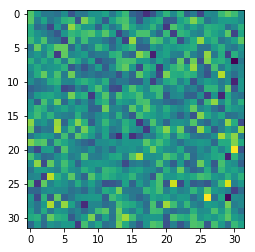

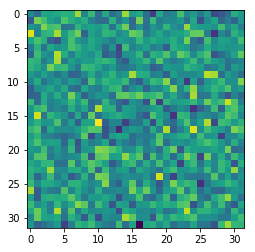

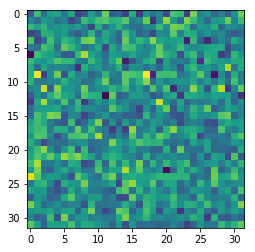

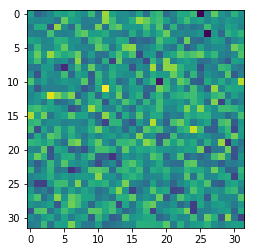

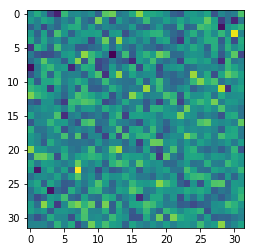

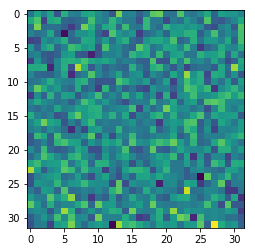

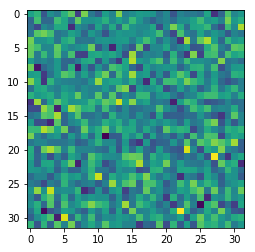

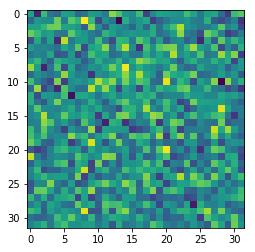

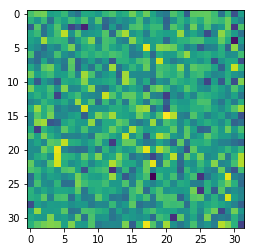

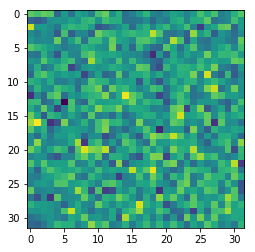

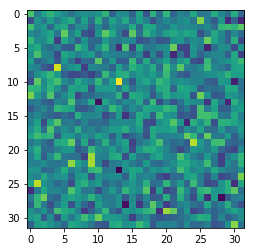

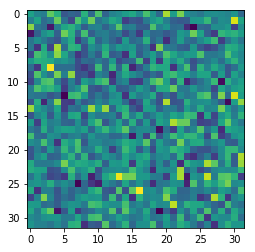

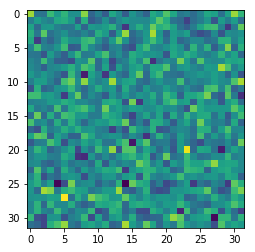

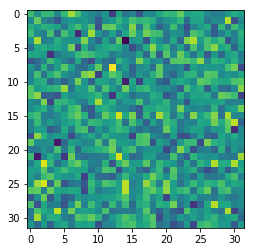

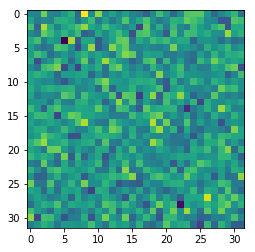

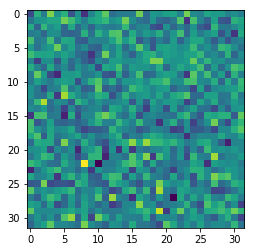

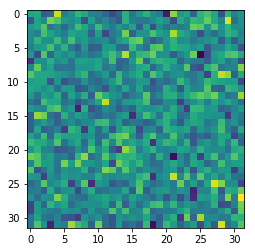

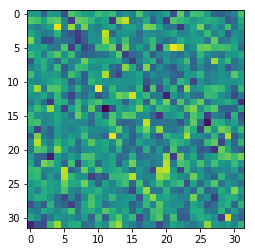

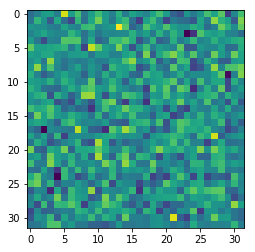

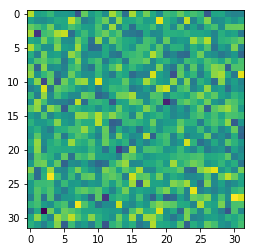

In [159]:
# visualize first 20 components
for i in range(20):
    components = data_transformed[:, i]
    vis = components.reshape((32, 32))

    f, axes = plt.subplots()
    axes.imshow(vis)


In [160]:
for n_component in range(90, 110, 1):
    new_single = single_data.copy()
    new_single[0, :] += last_component * factor
    U, S, V = svd(new_single, full_matrices=False)
    U, S, V = U[:, :n_component], S[:n_component], V[:n_component]
    reconstructed_data = ((new_single @ V.T) @ V)
    norm_diff = diffsnorm(reconstructed_data, new_single)
    print(f"norm difference wih {n_component} components using full batch data: {norm_diff}")

norm difference wih 90 components using full batch data: 0.05618957763587442
norm difference wih 91 components using full batch data: 0.05266236552620697
norm difference wih 92 components using full batch data: 0.04895851411196974
norm difference wih 93 components using full batch data: 0.045023091116660446
norm difference wih 94 components using full batch data: 0.040838939256129955
norm difference wih 95 components using full batch data: 0.036267870904144385
norm difference wih 96 components using full batch data: 0.03111540646750655
norm difference wih 97 components using full batch data: 0.025146509867190556
norm difference wih 98 components using full batch data: 0.017580137178137733
norm difference wih 99 components using full batch data: 0.002196945540286977
norm difference wih 100 components using full batch data: 6.496689027319819e-16
norm difference wih 101 components using full batch data: 6.44704352384082e-16
norm difference wih 102 components using full batch data: 6.72469

## Differing intensities of component vectors

In [161]:
for j in range(-1, -100, -10):
    for n_components in range(99, 101, 1):
        scaled_data = scale_data(data, order=j)
        data_transformed, reconstructed_data = run_pca(scaled_data, n_components)
        norm_diff = diffsnorm(reconstructed_data, scaled_data)
        print(f"norm difference between original and reconstructed data using {n_components} components: {norm_diff}")
        
        reconstruct_diff, benchmark_diff, transformed_diff = compare_benchmark(scaled_data)
        print(f"reconstruct norm difference : {reconstruct_diff}, benchmark norm difference : {benchmark_diff}, transformed norm difference : {transformed_diff}")

norm difference between original and reconstructed data using 99 components: 0.01043167083116219
reconstruct norm difference : 5.161341732904958e-16, benchmark norm difference : 9.346570261463054e-16, transformed norm difference : 3.10105997619131e-14
norm difference between original and reconstructed data using 100 components: 5.779290403187273e-16
reconstruct norm difference : 5.779290403187273e-16, benchmark norm difference : 1.0627133112854846e-15, transformed norm difference : 5.430310683196067e-14
norm difference between original and reconstructed data using 99 components: 0.0011973712424396647
reconstruct norm difference : 4.519692552956029e-16, benchmark norm difference : 7.142684651478477e-16, transformed norm difference : 2.2853414762262588e-14
norm difference between original and reconstructed data using 100 components: 4.1465275560940086e-16
reconstruct norm difference : 4.1465275560940086e-16, benchmark norm difference : 6.44385374107849e-16, transformed norm difference : 

## Add Gausian noise to the data

In [162]:
def find_noise_threshold(data, factor=0.01):
    norm_diff = 1
    
    while norm_diff > 1e-3:
        data_transformed, reconstructed_data = run_pca(data, 100, noise_factor=factor)
        norm_diff = diffsnorm(reconstructed_data, data)
        
        if norm_diff <= 1e-3:
            print(f"Using {factor} for factor of a normal distribution as an upper bound, the PCA works well")
            return
        
        factor /= 5

In [163]:
# single component contained in a single frame
find_noise_threshold(single_data)

Using 0.002 for factor of a normal distribution as an upper bound, the PCA works well


In [164]:
# scale the components to check the intensity
find_noise_threshold(scaled_data)

Using 0.002 for factor of a normal distribution as an upper bound, the PCA works well


In [165]:
# orthonormal dataset
find_noise_threshold(data)

Using 0.002 for factor of a normal distribution as an upper bound, the PCA works well


In [166]:
compare_benchmark(data)

(6.019234375436117e-16, 1.004854073176606e-15, 1.0159927979744206e-13)

In [167]:
compare_benchmark(single_data)

(5.012471421635519e-16, 9.233597701792534e-16, 1.4311835874373383e-13)

In [168]:
compare_benchmark(scaled_data)

(2.3640170228936684e-16, 2.2097410878640252e-16, 1.7361614417497936e-15)

## loading drawn from heavy tail distribution

In [169]:
# Use exponential distribution
loading = np.random.exponential(scale=np.log(2), size=(1024, 100))
exp_data = loading @ component
np.random.shuffle(exp_data.T)

In [170]:
compare_benchmark(exp_data)

(7.230080130624489e-16, 1.219137176929483e-15, 1.6898315713511833e-13)

In [171]:
# Use gamma distribution
loading = np.random.gamma(0.00000005, 0.0000005, size=(1024, 100))
gamma_data = loading @ component
np.random.shuffle(gamma_data.T)

In [172]:
compare_benchmark(gamma_data)

/home/jae/anaconda3/envs/libertem/lib/python3.6/site-packages/sklearn/decomposition/incremental_pca.py:282: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio = S ** 2 / np.sum(col_var * n_total_samples)
/home/jae/anaconda3/envs/libertem/lib/python3.6/site-packages/sklearn/decomposition/incremental_pca.py:282: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio = S ** 2 / np.sum(col_var * n_total_samples)
/home/jae/anaconda3/envs/libertem/lib/python3.6/site-packages/sklearn/decomposition/incremental_pca.py:282: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio = S ** 2 / np.sum(col_var * n_total_samples)


(1.2448541865818802e-15, 2.7542301099268937e-15, 2.61660547112336e-15)

In [173]:
for i in range(10):
    perc = 1 - 1/(10^i)
    noise_frame_data = noise_frame(perc=perc)
    compare_benchmark(noise_frame_data)

In [174]:
noise_frame_data = noise_frame(perc=1)
compare_benchmark(noise_frame_data)

(6.155301026139397e-16, 1.013015346152661e-15, 9.424979081099788e-14)

## Loading as identity matrix or all ones matrix

In [175]:
loading = np.identity(1024)[:, :100]
id_data = loading @ component

In [176]:
compare_benchmark(id_data)

(1.4111438797566265e-14, 1.2125432543523247e-14, 0.5038551095340372)

In [177]:
loading = np.ones((1024, 1024))[:, :100]
one_data = loading @ component

In [178]:
compare_benchmark(one_data) # get error

/home/jae/anaconda3/envs/libertem/lib/python3.6/site-packages/sklearn/decomposition/pca.py:536: RuntimeWarning: divide by zero encountered in true_divide
  self.explained_variance_ / total_var.sum()
/home/jae/anaconda3/envs/libertem/lib/python3.6/site-packages/sklearn/decomposition/pca.py:536: RuntimeWarning: divide by zero encountered in true_divide
  self.explained_variance_ / total_var.sum()


(0.0, 0.0, 3.271195866374359e-15)

## Collinear basis vectors

In [179]:
collinear_base = np.random.rand(1, 1024)

for _ in range(99):
    collinear_base = np.vstack((collinear_base, (collinear_base[0, :]) * (1/np.random.rand())))
loading = np.random.rand(1024, 100)
data = loading @ collinear_base
np.random.shuffle(data.T)

compare_benchmark(data, 50)

(2.5757284774523836e-16, 1.6674209198940805e-16, 1.165466515793252e-15)

### The above result shows that standard PCA and the implemented PCA can equally well reduce the dimension of the matrix when the base is consisted of collinear vectors

## Bimodal distribution (exploit the hyperbox property)

In [180]:
import random
def bimodal(low1, high1, mode1, low2, high2, mode2, shape):
    """
    generate loading based on bimodal distribution
    """
    mat = np.zeros(shape)
    nrow = shape[0]; ncol = shape[1]
    
    for i in range(nrow):
        for j in range(ncol):
            toss = random.choice((1, 2))
            
            if toss == 1:
                mat[i, j] = random.triangular(low1, high1, mode1)
            else:
                mat[i, j] = random.triangular(low2, high2, mode2)
                
    return mat
    

In [181]:
loading = bimodal(-10, -9, -1, 8, 10, 9, (1024, 100))

In [182]:
bimodal_data = loading @ component

In [183]:
compare_benchmark(bimodal_data)

(8.768304919503933e-16, 1.7670485536415271e-15, 2.9073766006620623e-13)

## Another case to test the volatility of hyperbox method (Create a customized data)

In [184]:
# choose an outlier randomly by the specified proportion of the data
def outlier(mat, perc=0.005):
    
    """
    Given a data matrix, assign the specified percentage number of entries
    to be outliers (push to the extreme of either positive or negative direction)
    """
    nrow, ncol = mat.shape
    
    n = int(perc * nrow * ncol)
    
    for _ in range(n):
        i = np.random.randint(0, nrow)
        j = np.random.randint(0, ncol)
        
        mat[i, j] *= 1e9 * np.random.choice([-1, 1])
    
    return mat

In [185]:
loading = np.random.normal(0, 1e-5, size=(1024, 100))

loading = outlier(loading)
data = loading @ component

compare_benchmark(data)
    

(9.565247550283057e-16, 1.8447990189828204e-15, 8.56430107169139e-14)

In [186]:
def sdev(nrow, ncol):
    """
    Generate a matrix of samples that have different standard deviations by
    adjusting the value of loading matrix
    """
    for row in range(1, nrow+1):
        
        new_sample = np.random.normal(0, (row**2)*1e-8, size=(1, ncol))
        
        if row == 1:
            loading = new_sample

        else:
    
            loading = np.vstack((loading, new_sample))
        
    np.random.shuffle(loading)
    
    return loading

In [187]:
loading = sdev(1024, 100)
data = loading @ component
compare_benchmark(data)

(9.79929392797956e-16, 1.826678208424233e-15, 8.404966424319946e-14)

# Standard PCA vs Implemented PCA efficiency comparison <a name="paragraph2"></a>

## Comparing standard PCA with implemented PCA <a name="subparagraph21"></a>

## Differentiating the size of the data to check if there is a non-negligble time difference between the standard PCA and the implemented PCA

In [208]:
init = ortho_group.rvs(dim=2000)

In [209]:
n_component = 10
for i in range(8, 43, 2):
    n = i ** 2
    base = inits[:n_component, :n]
    loading = np.random.rand(n, n_component)
    data = loading @ base

    compare_benchmark(data, n_component, bool_time=True)
    

For the implemented PCA, it took 0.022263526916503906s. For standard PCA, it took 0.0015230178833007812s
For the implemented PCA, it took 0.010563850402832031s. For standard PCA, it took 0.0030922889709472656s
For the implemented PCA, it took 0.011031389236450195s. For standard PCA, it took 0.00822901725769043s
For the implemented PCA, it took 0.023027658462524414s. For standard PCA, it took 0.01303863525390625s
For the implemented PCA, it took 0.029969215393066406s. For standard PCA, it took 0.027800798416137695s
For the implemented PCA, it took 0.05949211120605469s. For standard PCA, it took 0.04180788993835449s
For the implemented PCA, it took 0.14274096488952637s. For standard PCA, it took 0.24709367752075195s
For the implemented PCA, it took 0.23750758171081543s. For standard PCA, it took 0.34620046615600586s
For the implemented PCA, it took 0.47609925270080566s. For standard PCA, it took 0.11385560035705566s
For the implemented PCA, it took 0.5596156120300293s. For standard PCA, 

### The above result was not expected. Naturally, it is expected that the time it takes to run implemented PCA, which is a distributed version, would be shorter than that of the standard PCA. One can draw several hypotheses on this result, with the most probable one being that the prototype version implemented in this notebook is not optimized to the level it is optimized in LiberTEM. Another issue could be that the size of the data is too small for the distributed version to work better than the standard version

For the implemented PCA, it took 0.006099700927734375s. For standard PCA, it took 0.0018422603607177734s
For the implemented PCA, it took 0.007846593856811523s. For standard PCA, it took 0.002859354019165039s
For the implemented PCA, it took 0.01611328125s. For standard PCA, it took 0.00881505012512207s
For the implemented PCA, it took 0.024323225021362305s. For standard PCA, it took 0.014271020889282227s
For the implemented PCA, it took 0.027715206146240234s. For standard PCA, it took 0.026595115661621094s
For the implemented PCA, it took 0.04231119155883789s. For standard PCA, it took 0.040483951568603516s
For the implemented PCA, it took 0.06445121765136719s. For standard PCA, it took 0.07150769233703613s
For the implemented PCA, it took 0.10552763938903809s. For standard PCA, it took 0.11351656913757324s
For the implemented PCA, it took 0.160658597946167s. For standard PCA, it took 0.042836666107177734s
For the implemented PCA, it took 0.40091967582702637s. For standard PCA, it too

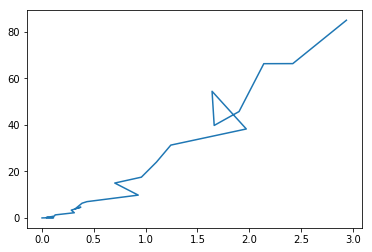

In [210]:
n_component = 10
inits = np.random.rand(5000, 5000)
new = []
orig = []

for i in range(8, 70, 2):
    n = i ** 2
    base = inits[:n_component, :n]
    loading = np.random.rand(n, n_component)
    data = loading @ base

    _, _, _, new_time, orig_time = compare_benchmark(data, n_component, bool_time=True)
    new.append(new_time)
    orig.append(orig_time)
    
plt.plot(orig, new)

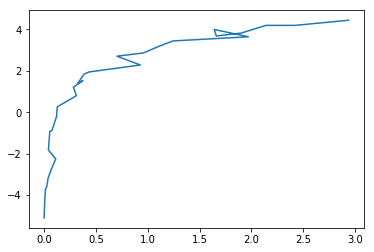

In [211]:
plt.plot(orig, np.log(new))

### We take a step further by investigating what the latency occurred in the implemented PCA. 

In [212]:
def time_run_pca(data, n_components=100, noise_factor=None, n_part=4):
        
    sig_dim = int(math.sqrt(data.shape[0]))
    nav_dim = int(math.sqrt(data.shape[1]))
    
    assert (sig_dim ** 2) == data.shape[0]
    assert (nav_dim ** 2) == data.shape[1]
    
    new_data = data.copy()
    
    if noise_factor:
        noise = np.random.normal(0, 0.1, size=(new_data.shape[0], new_data.shape[1])) * noise_factor
        new_data += noise
    
    # reformat data into sig and nav dimension
    new_data = new_data.reshape((sig_dim, sig_dim, nav_dim, nav_dim))
    
    start_part = time.time()
    
    partition = process_partition(new_data, n_components, n_part)
    
    end_part = time.time()
    
    start_merge = time.time()
    
    data_transformed, reconstructed_data = merge(new_data, partition, n_components)
    
    end_merge = time.time()
    
    print(f"processing partition took {end_part - start_part}s, merging the partitions took {end_merge - start_merge}s")
       
    return data_transformed, reconstructed_data, start_merge, end_merge

processing partition took 0.0011341571807861328s, merging the partitions took 0.0064699649810791016s
processing partition took 0.002394437789916992s, merging the partitions took 0.0071163177490234375s
processing partition took 0.002480745315551758s, merging the partitions took 0.009557485580444336s
processing partition took 0.003902912139892578s, merging the partitions took 0.013616561889648438s
processing partition took 0.007579803466796875s, merging the partitions took 0.022986888885498047s
processing partition took 0.011025428771972656s, merging the partitions took 0.03261590003967285s
processing partition took 0.018160343170166016s, merging the partitions took 0.051262855529785156s
processing partition took 0.032126665115356445s, merging the partitions took 0.09283900260925293s
processing partition took 0.06373715400695801s, merging the partitions took 0.12798333168029785s
processing partition took 0.09296226501464844s, merging the partitions took 0.2504093647003174s
processing par

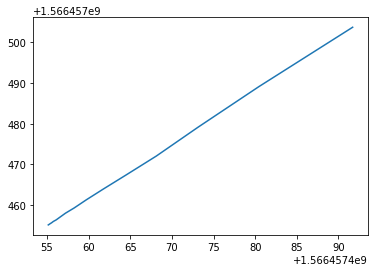

In [213]:
n_component = 10
inits = np.random.rand(5000, 5000)
new = []
orig = []

for i in range(8, 50, 2):
    n = i ** 2
    base = inits[:n_component, :n]
    loading = np.random.rand(n, n_component)
    data = loading @ base

    _, _, part_time, merge_time = time_run_pca(data, n_component)
    new.append(part_time)
    orig.append(merge_time)
    
plt.plot(new, orig)

### From the above result, it appears that merging phase takes most of the time taken. Note that merging phase utilizes the standard IPCA library (Incremental PCA) and perform partial fit on each of the partitions, whereas the standard PCA method performs fit on the full batch data at once. Then the question boils down to, how big should the data matrix be for Incremental PCA method to have advantage over standard full batch PCA?

For the implemented PCA, it took 0.05266976356506348s. For standard PCA, it took 0.0046122074127197266s
For the implemented PCA, it took 0.07054924964904785s. For standard PCA, it took 0.07083368301391602s
For the implemented PCA, it took 0.6745083332061768s. For standard PCA, it took 0.10644292831420898s
For the implemented PCA, it took 3.9324285984039307s. For standard PCA, it took 0.2998952865600586s


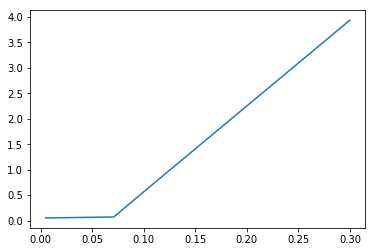

In [218]:
n_component = 10
inits = np.random.rand(10000, 10000)
new = []
orig = []

for i in range(10, 50, 10):
    n = i ** 2
    base = inits[:n_component, :n]
    loading = np.random.rand(n, n_component)
    data = loading @ base

    _, _, _, new_time, orig_time = compare_benchmark(data, n_component, bool_time=True)
    new.append(new_time)
    orig.append(orig_time)
    
plt.plot(orig, new)

Text(0, 0.5, 'implemented PCA')

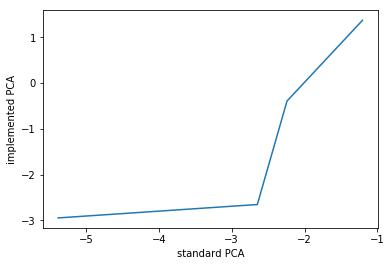

In [219]:
plt.plot(np.log(orig), np.log(new))
plt.xlabel("standard PCA")
plt.ylabel("implemented PCA")

### Unfortunately, it takes too long to compute once the matrix has more than 1e9 entries so it was not possible to verify when the implemented PCA outperforms the standard PCA, if ever. Another hypothesis is that it is simply incorrect to compare the performance of the implemented PCA with the standard PCA. IPCA, which is used in this prototype version of the implemented PCA, was originally designed not necessarily to improve the speed of the PCA algorithm, but to deal with a very large matrix in which the standard PCA could not fit the full data. Thus, the standard PCA algorithm would always outperform the implemented PCA, until the data becomes too big.

### To confirm the above hypothesis, we compare the performance of vanila PCA and vanila incremental PCA

In [220]:
compare_data = np.random.normal(0, 1, size=(1024, 1024))

start = time.time()
pca = PCA(n_components=9)
pca.fit(compare_data)

transformed_data = pca.fit_transform(compare_data)
pca_reconstruct = pca.inverse_transform(transformed_data)
end = time.time()

pca_time = end - start

start = time.time()
ipca = IncrementalPCA(n_components=9)

for i in range(4):
    ipca.partial_fit(data[i*256:i*256+256, :])

data_transformed = ipca.fit_transform(data)
ipca_reconstruct = ipca.inverse_transform(data_transformed)

end = time.time()

ipca_time = end - start

print(f"Vanile PCA takes {pca_time}s and vanila Incremental PCA takes {ipca_time}s")

Vanile PCA takes 0.1464066505432129s and vanila Incremental PCA takes 3.786435842514038s


## Effect of number of partitions <a name="subparagraph22"></a>

In [221]:
n_comp = 20

loading = np.random.rand(1024, 20)
data = loading @ component[:20]
np.random.shuffle(data.T)

i = 1

while i**2 <= 16:
    data_transformed, reconstructed_data = run_pca(data, n_components=n_comp, n_part=i**2)
    norm_diff = diffsnorm(reconstructed_data, data)
    print(f"norm difference between original and reconstructed data: {norm_diff} with {i**2} number of partitions")
    
    i += 1

norm difference between original and reconstructed data: 4.694764163831722e-16 with 1 number of partitions
norm difference between original and reconstructed data: 4.694764163831722e-16 with 4 number of partitions
norm difference between original and reconstructed data: 4.694764163831722e-16 with 9 number of partitions
norm difference between original and reconstructed data: 4.694764163831722e-16 with 16 number of partitions


### The above result shows that the number of partitions does not affect the performance of the algorithm